Converged after 11 iterations.


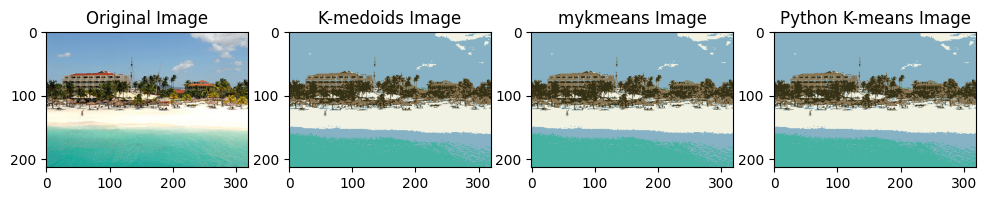

Converged after 30 iterations.


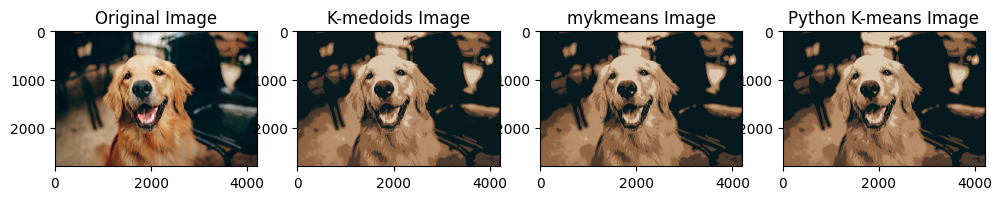

Converged after 23 iterations.


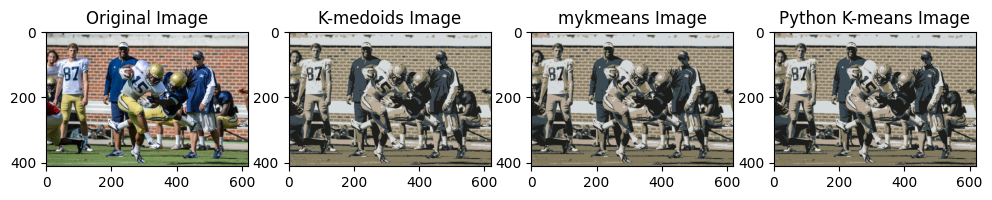

In [1]:
!pip install imageio
!pip install scikit-learn
!pip install scipy
import numpy as np
import imageio.v2 as imageio
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.sparse import csc_matrix
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import chebyshev
import scipy.sparse as sp
import sys
import os
import math


# Summarize the raw image data set features
# def summarize_array(array):
#     print("Image Data:")
#     print(array)
#     print("\nShape:", array.shape)
#     print("Size:", array.size)
#     print("Data type:", array.dtype)
#     print("Mean:", np.mean(array))
#     print("Min:", np.min(array))
#     print("Max:", np.max(array))
#     print("Standard deviation:", np.std(array))
#     print("Sum:", np.sum(array))
#     print("First element:", array.flat[0])

def mykmeans(pixels, K): 
    # be careful, 3-D image data should be reshaped to 2-D pixels data before input
    # Randomly initialize centroids within the data points; 
    centers = pixels[np.random.choice(pixels.shape[0], K, replace=False),:] 
    iterations = 200
    for iter in range(0, iterations):
        # norm squared of the centroids; 
        squared_of_centers = np.sum(np.power(centers.T, 2), axis = 0, keepdims = True)
        # in computing minimum Euclidean distance, we need to maximize the cross term
        cross_term = (2 * np.dot(pixels,centers.T) - squared_of_centers) 
        classes = np.argmax(cross_term, axis = 1)
        # update data assignment matrix; The assignment matrix is a sparse matrix, with size n x K. only the entries specified will be 1, others zeros
        update_assignment_matrix = csc_matrix( (np.ones(pixels.shape[0]) ,(np.arange(0,pixels.shape[0],1), classes)), shape=(pixels.shape[0], K) )
        # count the number of data points assigned to each cluster
        count = update_assignment_matrix.sum(axis=0)        
        # assign new clusters based on average value
        centers = np.array((update_assignment_matrix.T.dot(pixels)).T / count).T      
    return classes, centers    
    

def mykmedoids(pixels, K):
    # be careful, 3-D image data should be reshaped to 2-D pixels data before input   
    medoids = pixels[np.random.choice(pixels.shape[0], K, replace=False),:]  
    iterations = 200
    for iter in range(0, iterations):
        distances = np.array(compute_dist(pixels, medoids)) 
        classes = np.argmin(distances,axis=1)         
        
        # after clustering data sets into K groups, update the medoids by selecting one data point with lowest total distance with others within the group             
        new_medoids = np.zeros((K, pixels.shape[1]))
        for i in range(K): 
            # Only select data points which belong to the same group
            cluster_points = pixels[np.where(classes == i)[0]]
            if len(cluster_points) > 0:
                # distances = np.array(compute_dist(cluster_points, cluster_points)) # This way would compute too much out of memory                
                mean_point=np.mean(cluster_points,axis=0)             
                distances = np.linalg.norm(cluster_points - mean_point, axis=1)
                new_medoids_index = np.argmin(distances)                
                new_medoids[i]= cluster_points[new_medoids_index]
        
        # Check for convergence
        if np.all(medoids == new_medoids):
            print(f"Converged after {iter+1} iterations.")
            break
            
        medoids = new_medoids
        
    return classes, medoids   


def compute_dist(X,medoids):
    N,D = X.shape
    K = medoids.shape[0]
    return np.sqrt(np.sum((np.reshape(X,[N,1,D])-np.reshape(medoids,[1,K,D]))**2,axis=2))

def main():
    # Load the image files directly

    directory  = os.path.join(os.getcwd(), "content")  # Get the directory of the script    
    # Loop through all image files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
            image_file_name = os.path.join(directory, filename)
            K = 5  # You can adjust the number of clusters here

            im = np.asarray(imageio.imread(image_file_name))            
            pixels = im.reshape(-1, 3) # reshaple the 3-D data to 2-D data set


            # Apply K-medoids
            classes, centers = mykmedoids(pixels, K)
            mykmedoids_im = np.asarray(centers[classes].reshape(im.shape), im.dtype)
            imageio.imwrite(os.path.basename(os.path.splitext(image_file_name)[0]) + '_converted_mykmedoids_' + str(K) + os.path.splitext(image_file_name)[1], mykmedoids_im)
            
            # Apply K-means
            classes, centers = mykmeans(pixels, K)
            mykmeans_im = np.asarray(centers[classes].reshape(im.shape), im.dtype)
            imageio.imwrite(os.path.basename(os.path.splitext(image_file_name)[0]) + '_converted_mykmeans_' + str(K) + os.path.splitext(image_file_name)[1], mykmeans_im)
            
            # Directly call python function "kmeans"            
            kmeans = KMeans(n_clusters=K, random_state=0)
            kmeans.fit(pixels) 
            inertia = kmeans.inertia_ # sum of squared distances of samples to their closest cluster center
            iterations = kmeans.n_iter_ # The number of iterations the algorithm ran before convergence
            
            centers = kmeans.cluster_centers_ # Get the cluster centers and labels
            classes = kmeans.labels_
            replace_pixels_to_clusters = np.asarray(centers[classes].reshape(im.shape), im.dtype) # Map each pixel to the nearest cluster center, converts the data type of the array to uint8 ensures that the pixel values are in the range [0, 255]            
            pyfunc_image = replace_pixels_to_clusters.reshape(im.shape)  # Reshape back to the original image shape            
            
            fig, ax = plt.subplots(1, 4, figsize=(12, 6)) # Display the original and segmented images             
            ax[0].imshow(im)
            ax[0].set_title("Original Image")                  
            ax[1].imshow(mykmedoids_im)
            ax[1].set_title("K-medoids Image") 
            ax[2].imshow(mykmeans_im)
            ax[2].set_title("mykmeans Image") 
            ax[3].imshow(pyfunc_image)
            ax[3].set_title("Python K-means Image") 
            plt.show()
            


if __name__ == '__main__':
    main()